<a href="https://colab.research.google.com/github/Srikanthr7/Credit-card-default/blob/main/Credit_card_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import os

# Ensure file paths are correct
dev_data_path = '/content/Dev_data_to_be_shared.csv'
val_data_path = '/content/validation_data_to_be_shared.csv'

# Check if the files exist
if not os.path.exists(dev_data_path) or not os.path.exists(val_data_path):
    raise FileNotFoundError("One or both of the dataset files are missing. Please upload the correct files.")

# Load the data
dev_data = pd.read_csv(dev_data_path)
val_data = pd.read_csv(val_data_path)

# Data Cleaning (Check for missing values and fill/remove if necessary)
print("Missing values in development data:")
print(dev_data.isnull().sum())

if dev_data.isnull().values.any():
    dev_data = dev_data.fillna(dev_data.mean())

# Feature Selection (Select important features for the model)
selected_features = ['transaction_attribute_1', 'transaction_attribute_2', 'bureau_1']

if not all(feature in dev_data.columns for feature in selected_features):
    raise ValueError("Selected features are not present in the development dataset.")

if not all(feature in val_data.columns for feature in selected_features):
    raise ValueError("Selected features are not present in the validation dataset.")

X = dev_data[selected_features]
y = dev_data['bad_flag']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the Model using ROC-AUC
predictions = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, predictions)
print(f"AUC-ROC Score: {auc_score}")

# Predict on Validation Data
val_data[selected_features] = val_data[selected_features].fillna(0)
val_data['predicted_probability'] = model.predict_proba(val_data[selected_features])[:, 1]

# Save the results
output = val_data[['account_number', 'predicted_probability']]
output.to_csv('predictions.csv', index=False)

print("Predictions saved to 'predictions.csv'")


Missing values in development data:
account_number                 0
bad_flag                       0
onus_attribute_1           25231
transaction_attribute_1    25231
transaction_attribute_2    25231
                           ...  
onus_attribute_44          85196
onus_attribute_45          85196
onus_attribute_46          85196
onus_attribute_47          85196
onus_attribute_48          85196
Length: 1216, dtype: int64
AUC-ROC Score: 0.5340225147393003
Predictions saved to 'predictions.csv'


## Visualizing Predictions


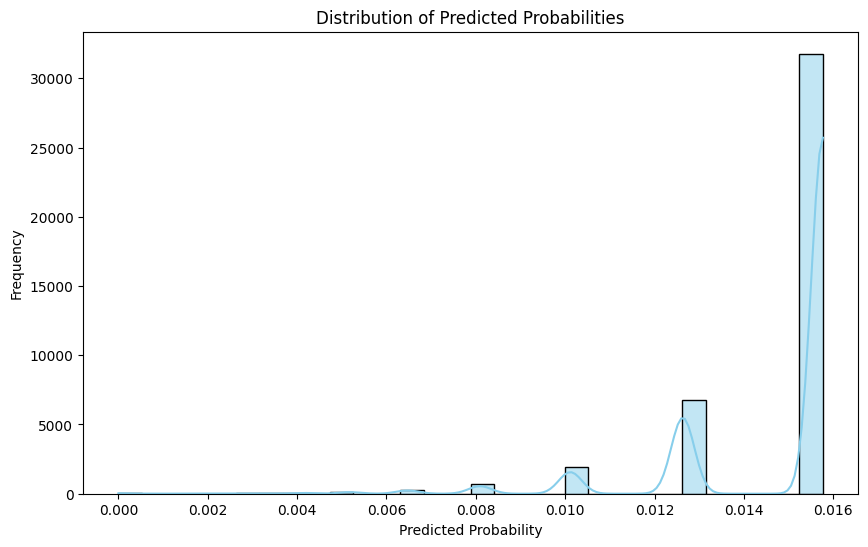

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(val_data['predicted_probability'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


# ROC Curve


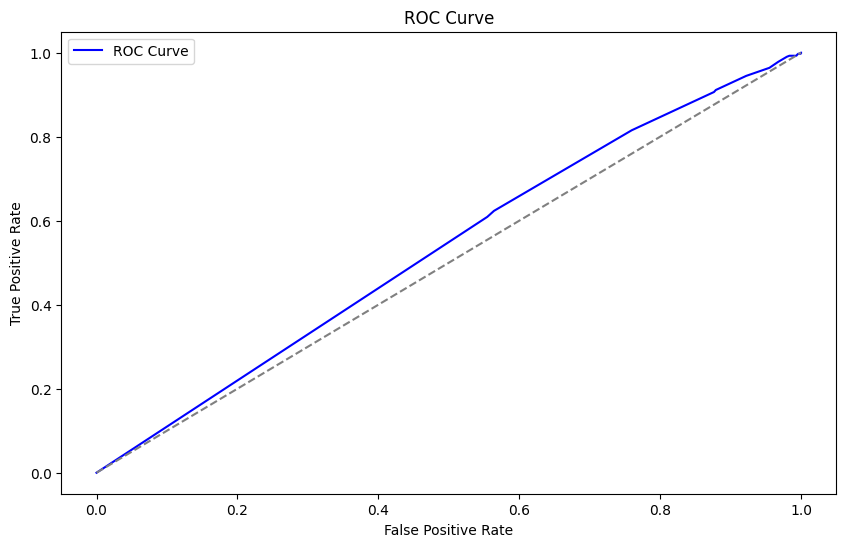

AUC-ROC Score: 0.5340225147393003


In [ ]:
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# You can also compute AUC if needed
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC Score: {roc_auc}")


# Confusion matrix


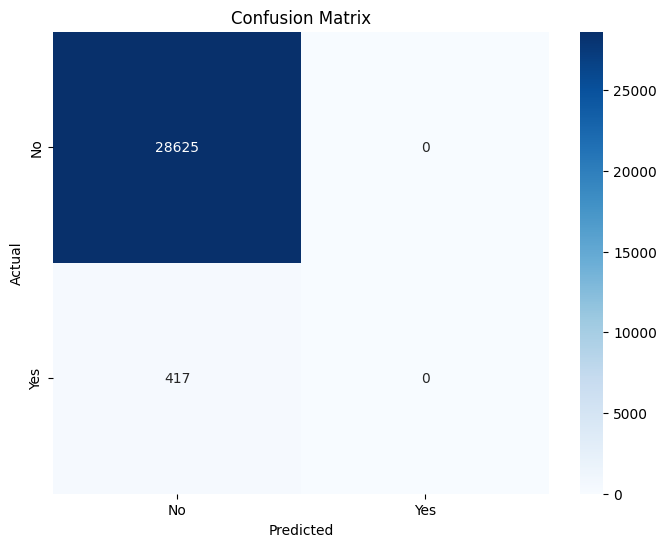

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Precision recall curve

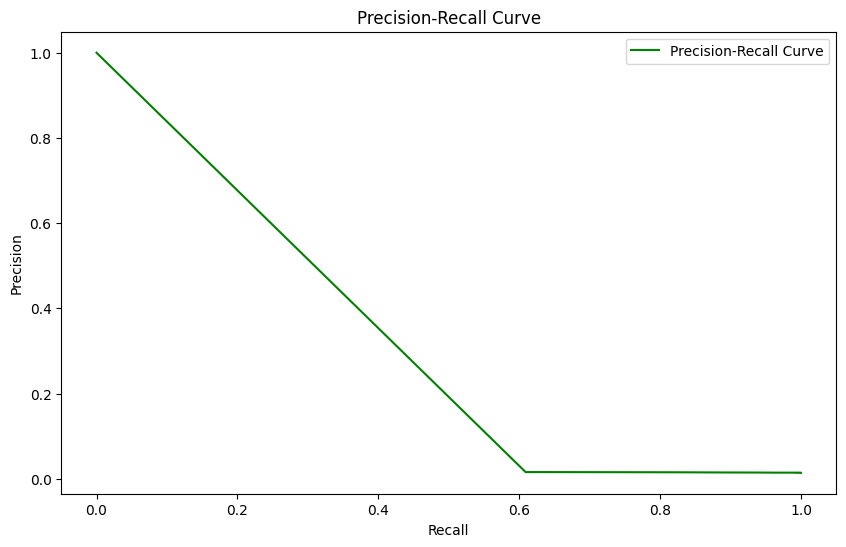

Average Precision Score: 0.01548992907225701


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, predictions)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Calculate and print the average precision score
average_precision = average_precision_score(y_test, predictions)
print(f'Average Precision Score: {average_precision}')


#Feature importance plot


<ipython-input-14-bdcfbab6bfaa>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette="viridis")


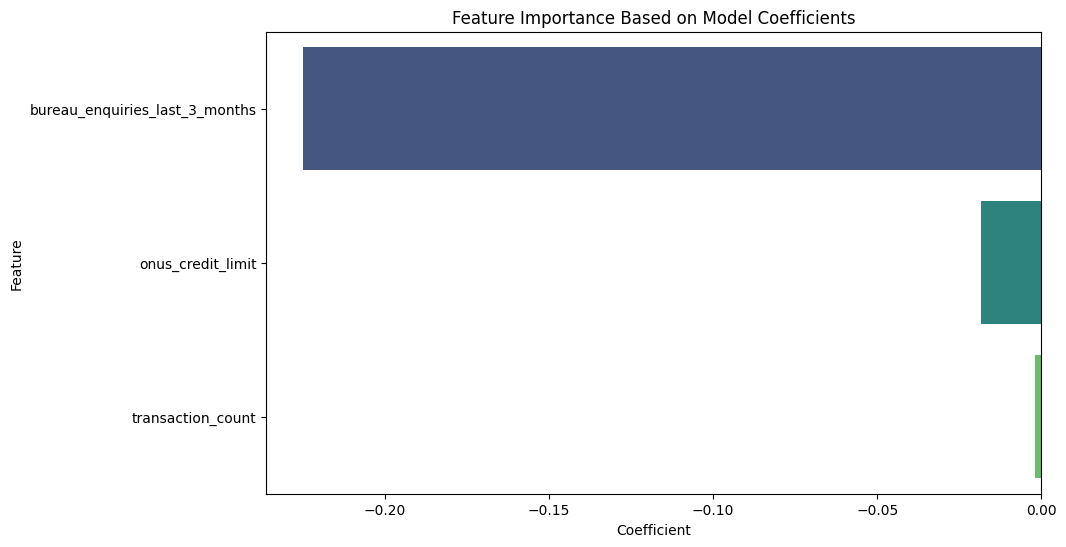

In [ ]:
# Plot feature importance based on model coefficients
coefficients = model.coef_[0]
feature_names = selected_features

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by the magnitude of the coefficient
feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette="viridis")
plt.title('Feature Importance Based on Model Coefficients')
plt.show()


#Learning Curve


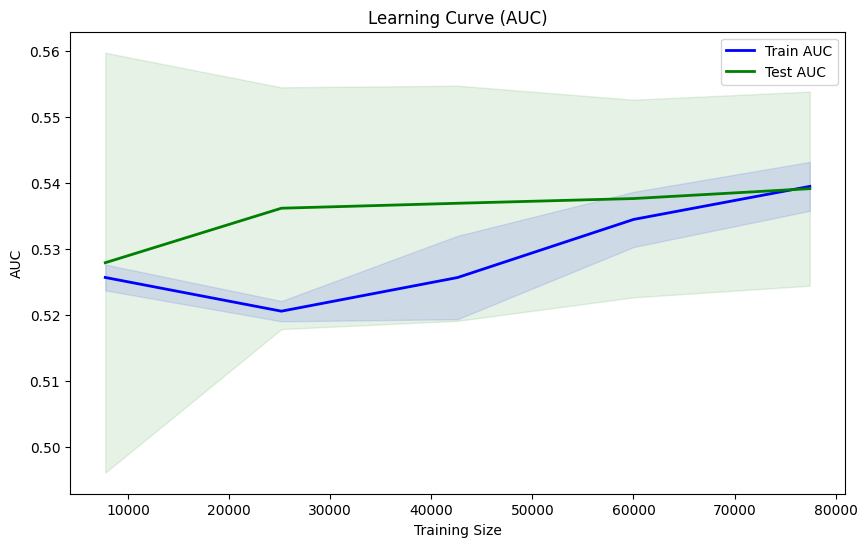

In [ ]:
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)

# Calculate the mean and std deviation for the learning curves
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Train AUC', color='blue', lw=2)
plt.plot(train_sizes, test_mean, label='Test AUC', color='green', lw=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve (AUC)')
plt.xlabel('Training Size')
plt.ylabel('AUC')
plt.legend(loc='best')
plt.show()


# Caliberation curve

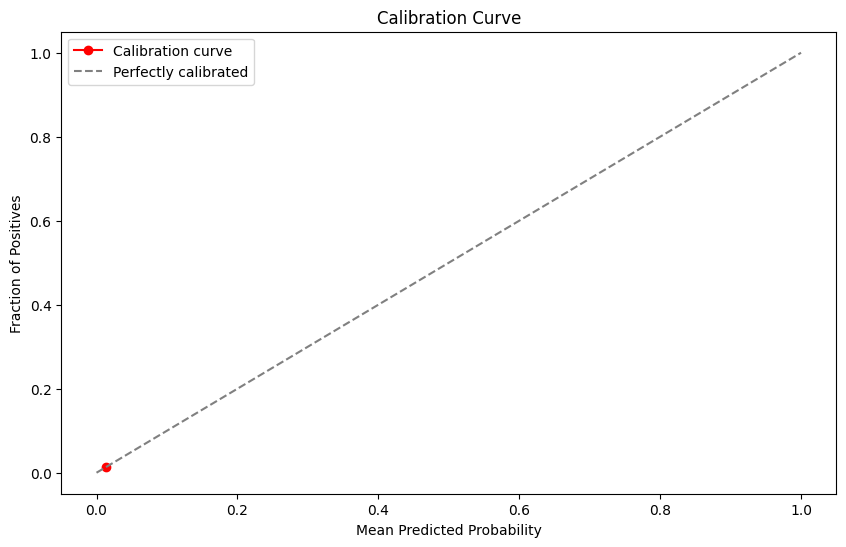

In [ ]:
from sklearn.calibration import calibration_curve

# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, predictions, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', color='red', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')
plt.show()


#Pair plot

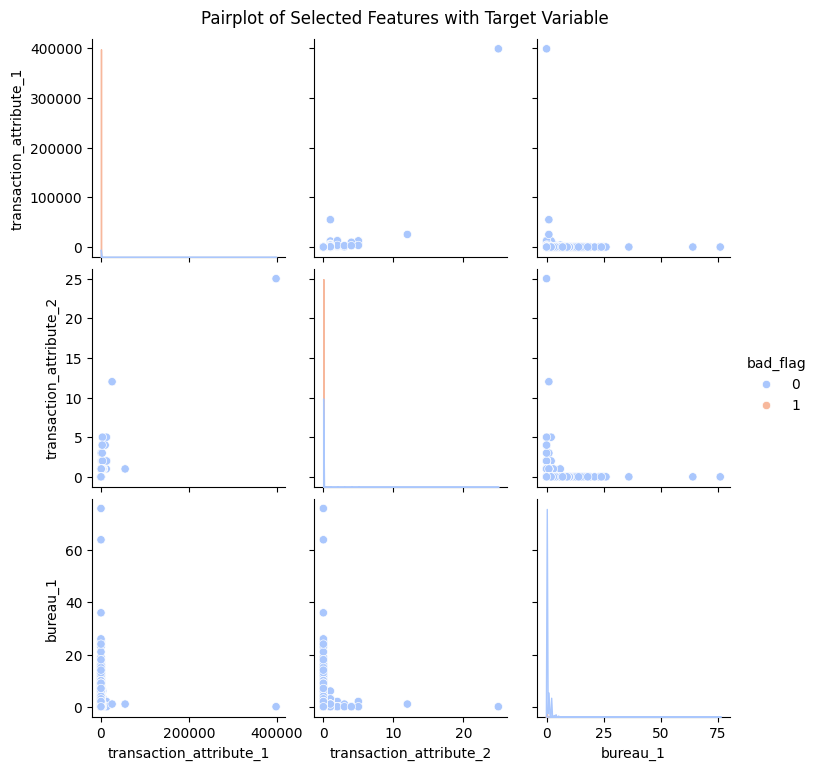

In [ ]:
import seaborn as sns

# Verify the correct columns
selected_features = ['transaction_attribute_1', 'transaction_attribute_2', 'bureau_1']  # Update with your actual feature names

# Plot pairplot with valid hue and selected features
sns.pairplot(dev_data, hue="bad_flag", vars=selected_features, palette='coolwarm')
plt.suptitle('Pairplot of Selected Features with Target Variable', y=1.02)
plt.show()




# Cumulative gain

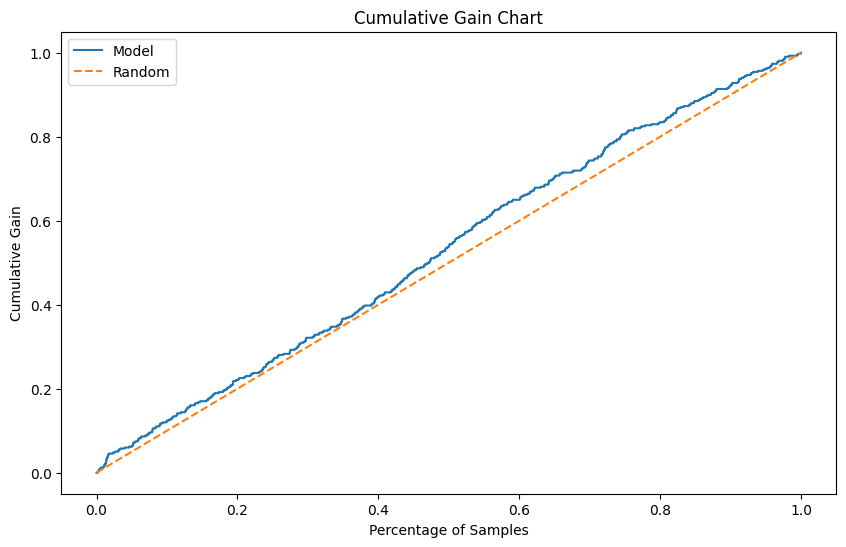

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Sort predicted probabilities and corresponding true labels
sorted_indices = np.argsort(predictions)[::-1]
sorted_true_labels = y_test.iloc[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Compute the cumulative gain
cumulative_gain = np.cumsum(sorted_true_labels) / np.sum(sorted_true_labels)

# Plot cumulative gain chart
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_gain) + 1) / len(cumulative_gain), cumulative_gain, label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.title('Cumulative Gain Chart')
plt.xlabel('Percentage of Samples')
plt.ylabel('Cumulative Gain')
plt.legend(loc='best')
plt.show()
